In [13]:
REPO = '..'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import pickle
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scoring difference

In [14]:
scores_path = f'{RESULT_TABLE}/MPs/Tumor/signature_scores.csv'
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
with open(f'{RESULT_TABLE}/MPs/Tumor/MP_anno_map.pickle', "rb") as input_file:
    MP_anno_map= pickle.load(input_file)
MP_anno_map_reverse = {v:k for k,v in MP_anno_map.items()}
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
scores = scores.merge(sample_meta,on='CCG_ID',how='left')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)


In [19]:
order = ['EMT-I', 'EMT-II','EMT-III','ER-I', 'ER-II','Stress', 'Cell_Cycle',  'Apelin',
         'Interferon/MHCII(I)']

# Treatment-induced program shifts

## Monotherapy
### Chemotherapy induced MPs shift

In [20]:
tx_arm = 'Chemo->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,EMT-I,-0.157873,-2.018717,2.963190544661249e-27,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,EMT-I,-0.132281,-1.659531,1.3536319663781253e-19,favorable response\n(RCB 0-I),0.0
0,Baseline,W3D1,EMT-I,-0.275004,-1.659531,1.913414108093322e-08,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Stress,-0.002401,-0.42151,0.8202962341983282,favorable response\n(RCB 0-I)+unfavorable resp...,0.827804
0,Baseline,W3D1,Cell_Cycle,-0.040493,-0.147315,0.10513319568234974,favorable response\n(RCB 0-I),0.118275
0,Baseline,W3D1,Cell_Cycle,0.022747,-0.147315,0.49274928033382326,unfavorable response\n(RCB II-III),0.554343
0,Baseline,W3D1,ER-I,-0.022253,-0.040218,0.30718689899789536,unfavorable response\n(RCB II-III),0.46078
0,Baseline,W3D1,ER-I,-0.001433,-0.040218,0.9593127655131327,favorable response\n(RCB 0-I),0.959313
0,Baseline,W3D1,Cell_Cycle,-0.029153,-0.03375,0.17681308953935232,favorable response\n(RCB 0-I)+unfavorable resp...,0.227331
0,Baseline,W3D1,ER-I,-0.005166,-0.01432,0.8278044394028883,favorable response\n(RCB 0-I)+unfavorable resp...,0.827804


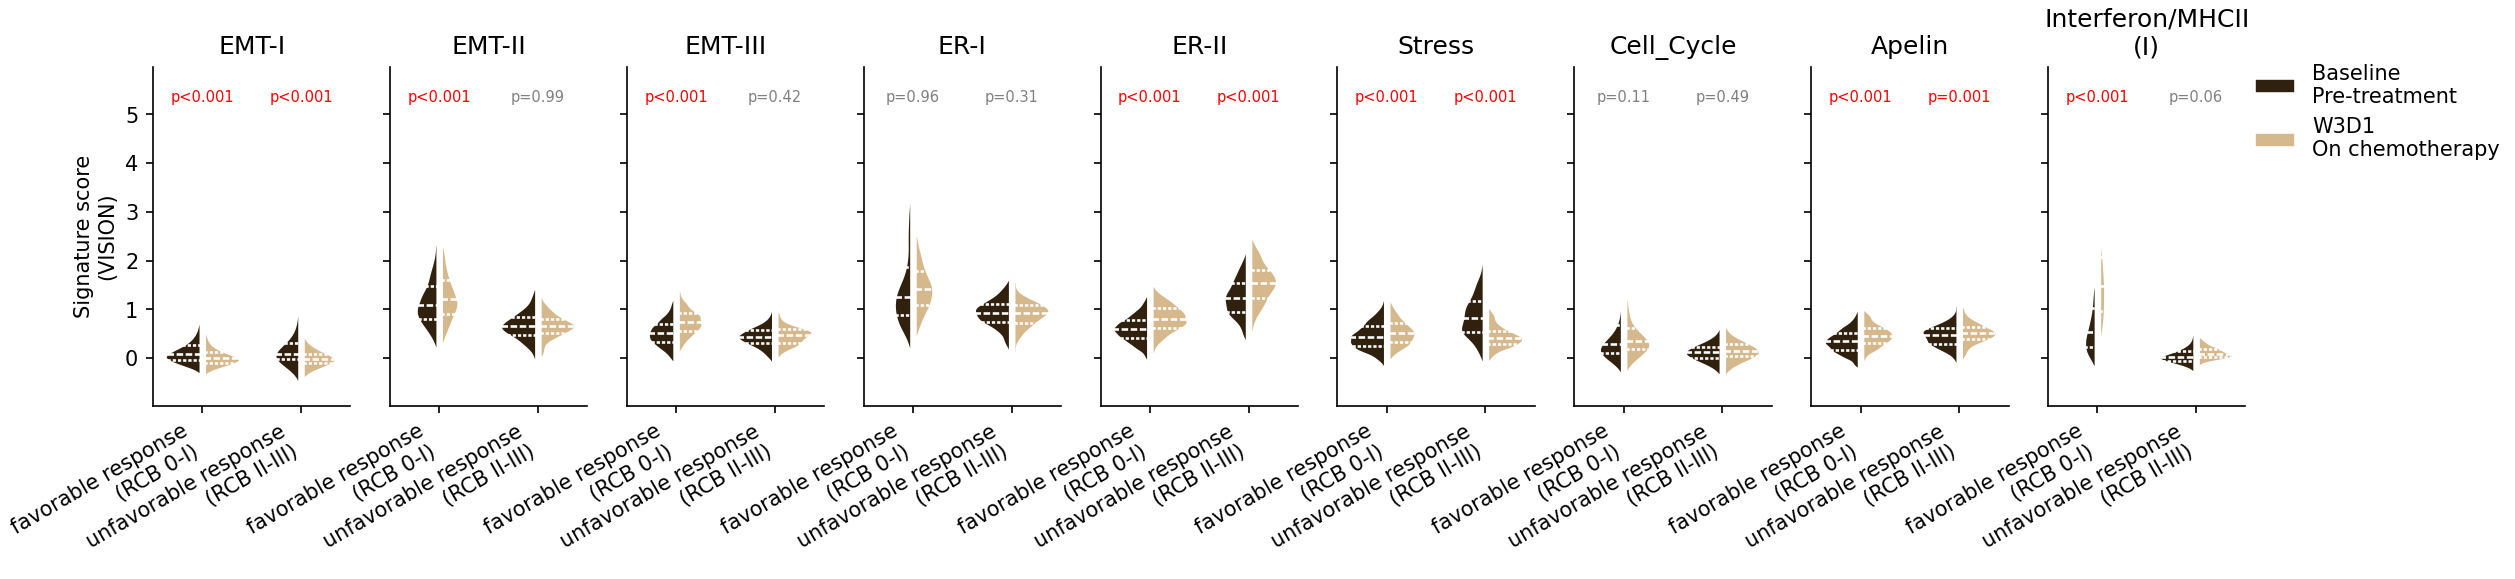

In [24]:
show_mps = order
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(len(show_mps)*2,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=len(show_mps)-1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn chemotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype.replace('(','\n('),ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.savefig(f'{FIGURE_FOLDER}/FigX_Tumor_signature_ChemoVsBaseline.svg',dpi=200,bbox_inches='tight')

### Pembro induced MPs shifts

In [25]:
tx_arm = 'ICI->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y',explored_z])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         0
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,Stress,-0.259282,-0.91306,0.0,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,EMT-I,-0.169853,-0.858243,1.3082008110312216e-105,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,ER-II,0.007783,-0.025624,0.14534010420903085,unfavorable response\n(RCB II-III),0.14534
0,Baseline,W3D1,Apelin,0.083253,0.052169,2.879575998075828e-19,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Interferon/MHCII(I),0.032529,0.065122,2.5513338159545947e-07,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,EMT-III,0.026479,0.071324,1.764563349609202e-08,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Cell_Cycle,0.024546,0.126956,0.01552952011423991,unfavorable response\n(RCB II-III),0.017471
0,Baseline,W3D1,EMT-II,0.231038,0.212866,3.349222245692064e-257,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,ER-I,0.494571,0.267159,0.0,unfavorable response\n(RCB II-III),0.0


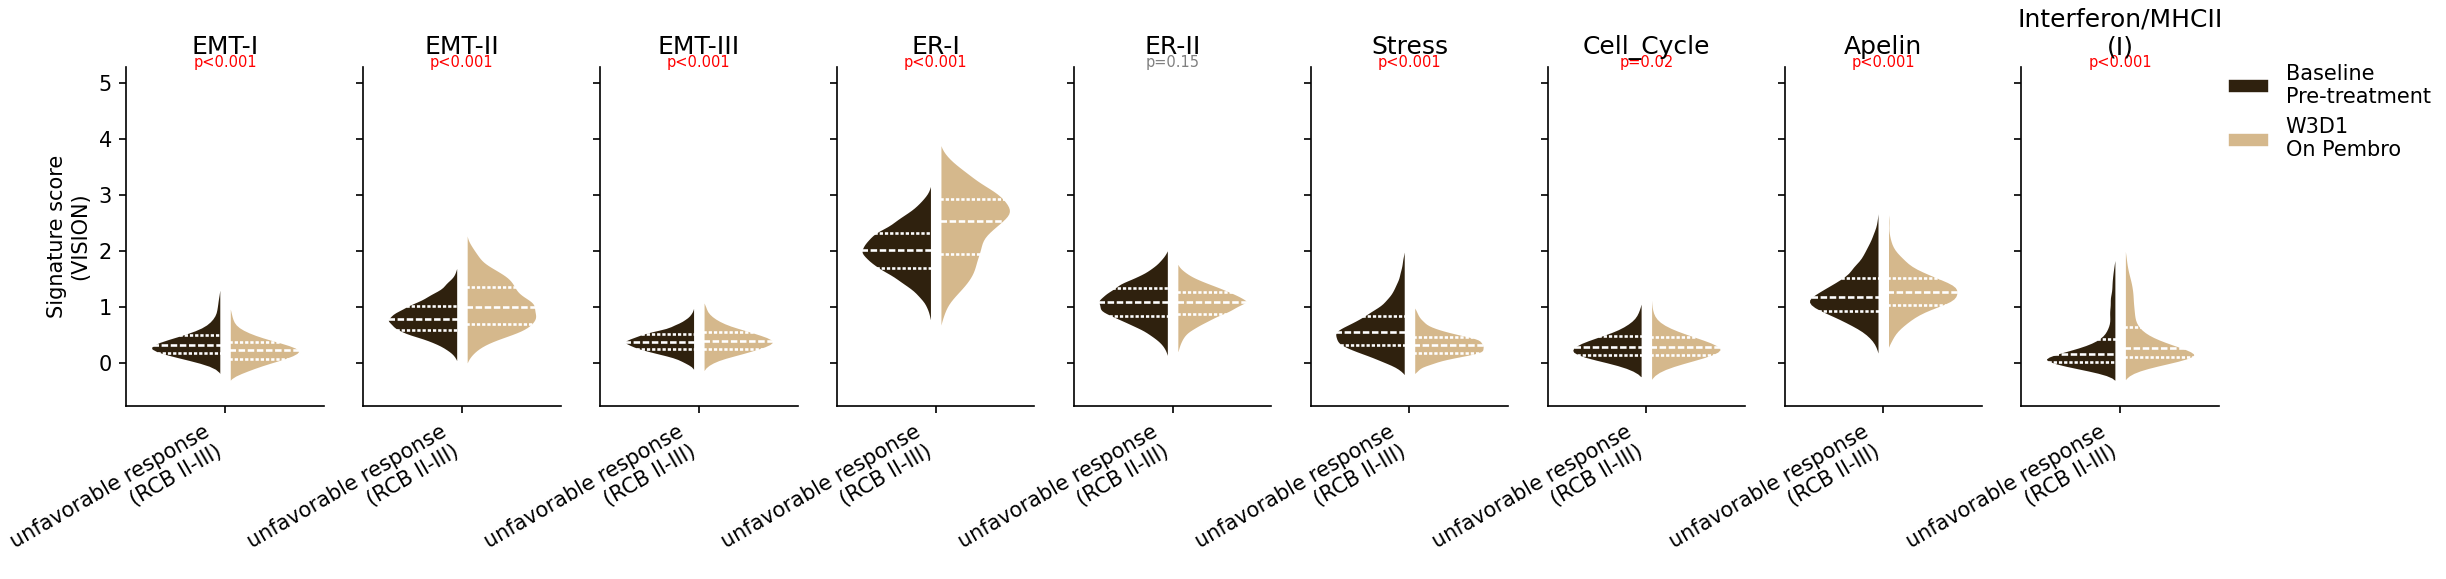

In [27]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(len(show_mps)*2,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=len(show_mps)-1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn Pembro'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype.replace('(','\n('),ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.savefig(f'{FIGURE_FOLDER}/FigX_Tumor_signature_PembroVsBaseline.svg',dpi=200,bbox_inches='tight')

## Combination induced MPs shifts

In [28]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W3D1,W7D1,Interferon/MHCII(I),-0.083474,-0.854604,2.0761602018799767e-77,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,Interferon/MHCII(I),0.347332,-0.854604,3.511079594350758e-08,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,Cell_Cycle,-0.099802,-0.552499,3.263304642973276e-55,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,W3D1,W7D1,Cell_Cycle,-0.254476,-0.46104,9.762142941722601e-11,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,Cell_Cycle,-0.09224,-0.46104,5.795075598356245e-48,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,EMT-III,-0.100945,-0.303763,4.482923915852125e-07,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,EMT-III,-0.035131,-0.303763,3.626665458275279e-12,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,ER-II,0.020174,-0.258977,1.0345685606283819e-05,favorable response\n(RCB 0-I)+unfavorable resp...,0.000012
0,W3D1,W7D1,EMT-I,-0.125368,-0.257444,1.4393697871170561e-18,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,EMT-I,0.220116,-0.257444,1.5055717868029614e-19,favorable response\n(RCB 0-I),0.0


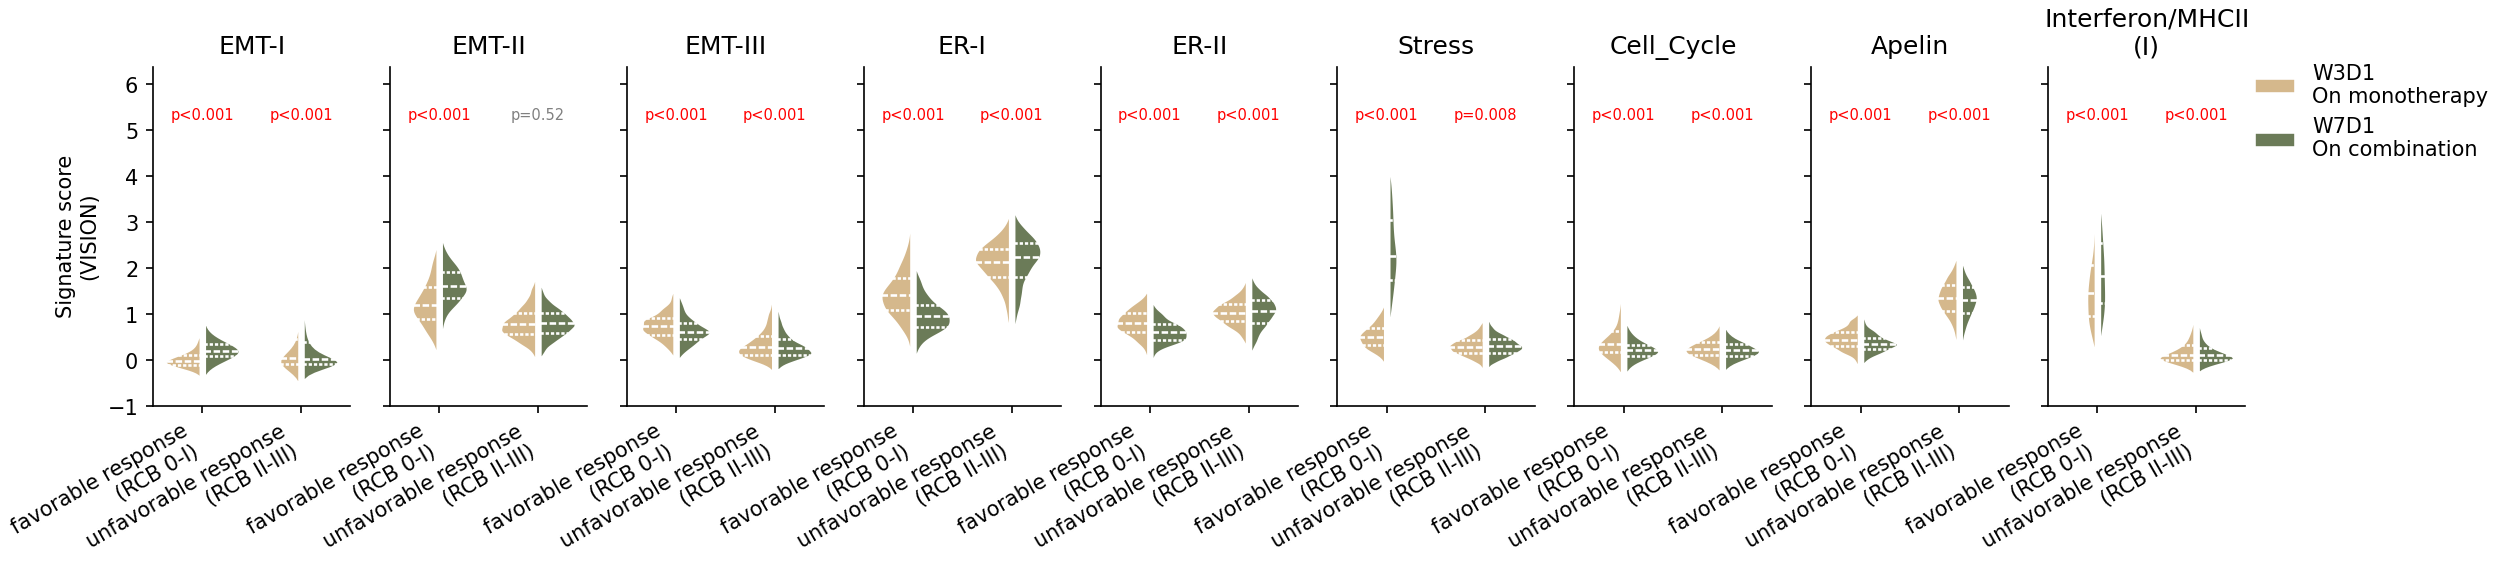

In [29]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(len(show_mps)*2,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=len(show_mps)-1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'W3D1':'W3D1\nOn monotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype.replace('(','\n('),ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.savefig(f'{FIGURE_FOLDER}/FigX_Tumor_signature_ComboVsMono.svg',dpi=200,bbox_inches='tight')

## Combination + AC

In [30]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Pre-surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Pre-surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Pre-surgery,Interferon/MHCII(I),-0.120343,-0.671036,7.098576184276039e-16,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,Cell_Cycle,-0.120754,-0.65625,0.3839419398481081,favorable response\n(RCB 0-I),0.431935
0,W7D1,Pre-surgery,Cell_Cycle,-0.179566,-0.65625,1.1985746737403997e-22,unfavorable response\n(RCB II-III),0.0
0,W7D1,Pre-surgery,Cell_Cycle,-0.179126,-0.589599,8.580082440971493e-23,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,EMT-III,0.356037,-0.303131,1.727674478992278e-147,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,Interferon/MHCII(I),-0.325973,-0.298591,0.0005279463413250175,favorable response\n(RCB 0-I),0.004752
0,W7D1,Pre-surgery,Interferon/MHCII(I),-0.118795,-0.298591,2.453057199914866e-15,unfavorable response\n(RCB II-III),0.0
0,W7D1,Pre-surgery,Stress,-0.004565,-0.29679,0.6252360675442896,unfavorable response\n(RCB II-III)+favorable r...,0.625236
0,W7D1,Pre-surgery,EMT-II,0.254418,-0.252347,2.4996533560924987e-128,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,EMT-I,0.31373,-0.058647,1.365589629494861e-35,unfavorable response\n(RCB II-III)+favorable r...,0.0


In [31]:
dt.groupby([explored_z])['AC_Treatment'].unique()

BestResponse
favorable response\n(RCB 0-I)         [Yes]
unfavorable response\n(RCB II-III)    [Yes]
Name: AC_Treatment, dtype: object

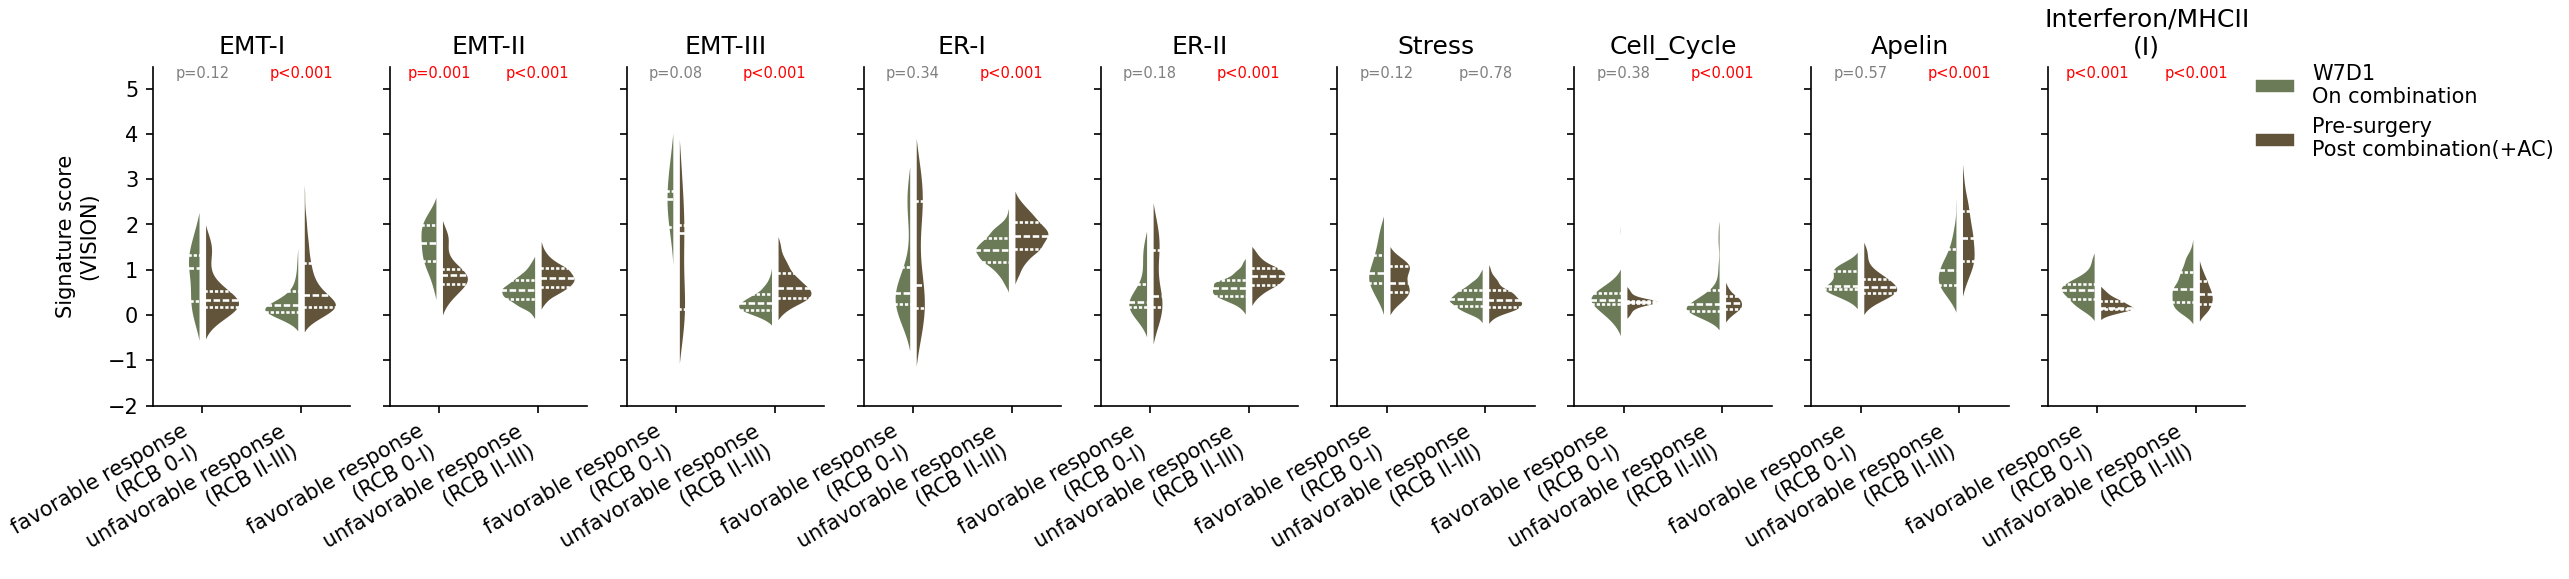

In [32]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(len(show_mps)*2,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=len(show_mps)-1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'Pre-surgery':'Pre-surgery\nPost combination(+AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype.replace('(','\n('),ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.savefig(f'{FIGURE_FOLDER}/FigX_Tumor_signature_PostVsCombo.svg',dpi=200,bbox_inches='tight')

## On surgery - post treatment

In [33]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y','BestResponse'])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    0
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Surgery,Stress,-1.578368,-2.895235,0.0,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,EMT-I,-0.325659,-1.064548,8.302553248548941e-73,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,EMT-III,-0.52656,-1.051011,4.6861965843546565e-91,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,Apelin,-0.442657,-0.655181,6.480075006396773e-117,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,EMT-II,-0.557663,-0.556252,1.8739681676006056e-76,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,Cell_Cycle,-0.086954,-0.330218,2.3515858281229251e-07,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,ER-II,-0.360107,-0.295438,8.501006183195854e-25,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,Interferon/MHCII(I),-0.017201,-0.19031,0.1086162740367834,favorable response\n(RCB 0-I),0.108616
0,W7D1,Surgery,ER-I,0.482708,0.33322,3.406057601294028e-55,favorable response\n(RCB 0-I),0.0


In [34]:
dt.groupby([explored_z])['AC_Treatment'].unique()

BestResponse
favorable response\n(RCB 0-I)    [No]
Name: AC_Treatment, dtype: object

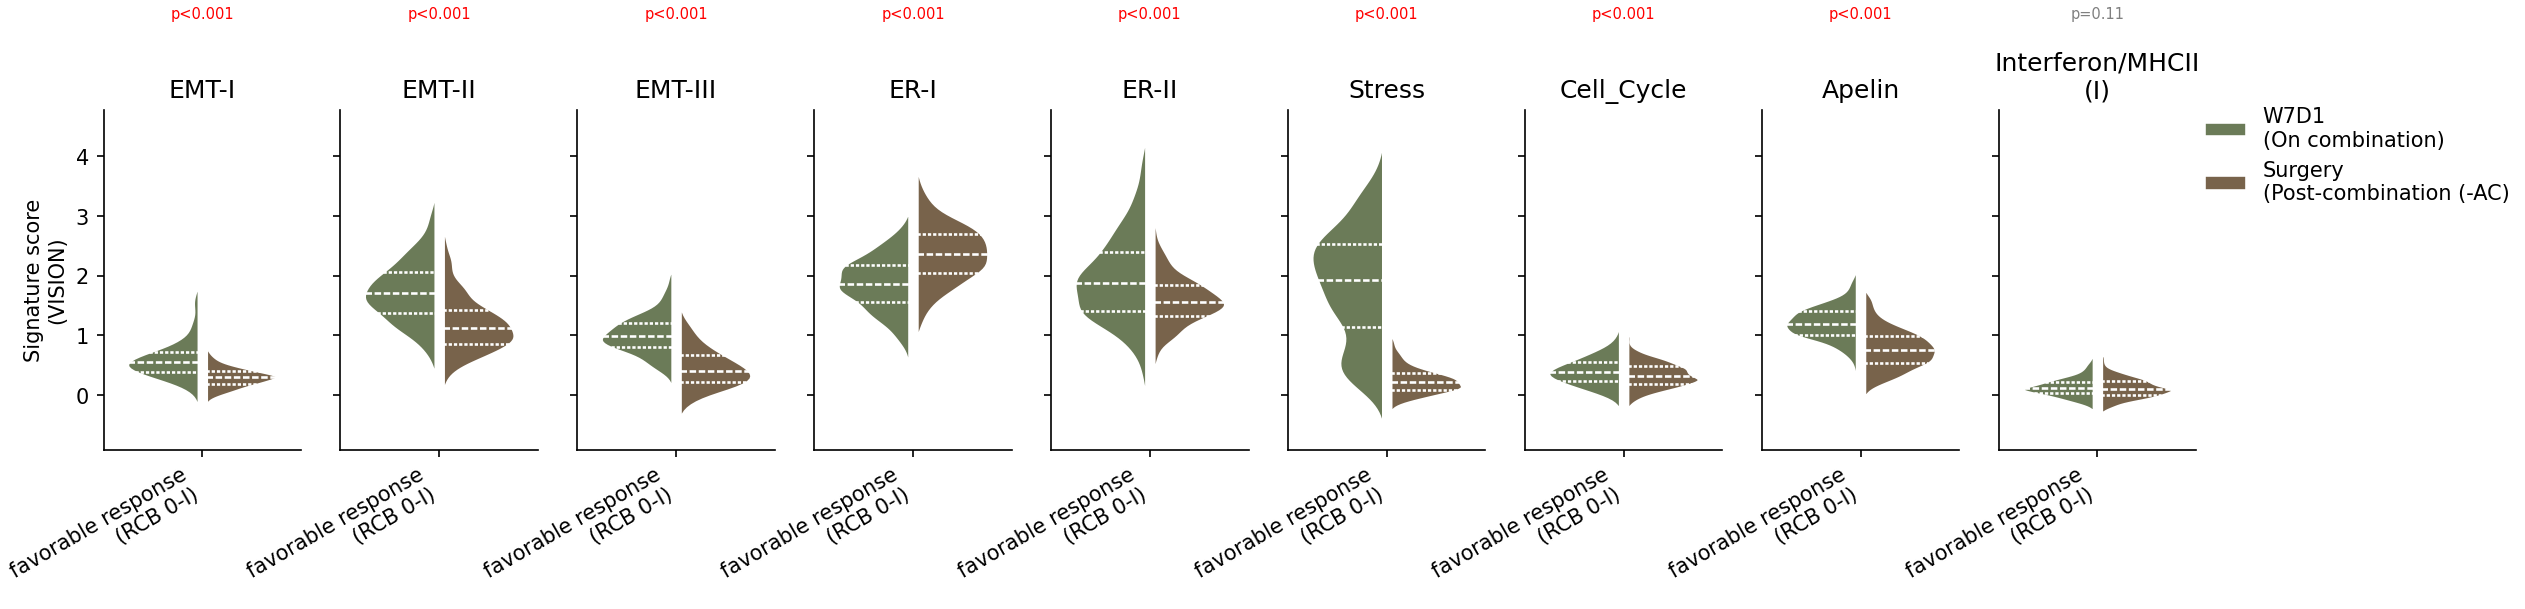

In [35]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(len(show_mps)*2,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =6.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=len(show_mps)-1:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\n(On combination)',
                        'Surgery':'Surgery\n(Post-combination (-AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype.replace('(','\n('),ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.savefig(f'{FIGURE_FOLDER}/FigX_Tumor_signature_SurgeryVsCombo.svg',dpi=200,bbox_inches='tight')